In [3]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

from utilities import *
from torch.nn import Module, Sequential, Conv2d, BatchNorm2d, ReLU, MaxPool2d, AvgPool2d, Linear, Dropout, CrossEntropyLoss
from torch.optim import SGD, Adam
from tqdm import tqdm

In [4]:
# Set seeds for reproducibility
# fix this
seed = 203
torch.manual_seed(seed)

In [5]:
dir_init = './doppler_traces/' #Directory of data
subdirs_init = 'S1a' #Subdirs for training

In [6]:
dataset_csi_train = create_training_set(dir_init=dir_init, subdirs_init=subdirs_init)
dataset_csi_val = create_validation_set(dir_init=dir_init, subdirs_init=subdirs_init)
dataset_csi_test = create_test_set(dir_init=dir_init, subdirs_init=subdirs_init)

#### Model training

In [7]:
from ResNet50 import ResNet50

model = ResNet50()
opt = Adam(model.parameters(), lr=0.0001)
loss_fn = CrossEntropyLoss() # by default reduction="mean" i.e. the output is a scalar
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

epochs=15
best_val = np.inf
train_error = []
validation_error = []
for epoch in range(epochs):
    train_loss = []
    model.train()
    print(f"Epoch: {epoch+1}")
    iterator = tqdm(dataset_csi_train) # iterate over the batches
    for batch_x, batch_y in iterator:
        batch_x = batch_x.to(device) # batch with the inputs
        batch_y = batch_y.to(device) # batch with the labels
        batch_y = t.squeeze(batch_y, dim=1)

        y_pred = model(batch_x) 

        loss = loss_fn(y_pred, batch_y)
 
        opt.zero_grad() 
        loss.backward() #how is it bound to the model?
        opt.step()
        train_loss.append(loss.detach().cpu().numpy())
        iterator.set_description(f"Train loss: {loss.detach().cpu().numpy()}")
    train_error.append(np.mean(train_loss))

    # validation
    model.eval() # what does this change?
    with torch.no_grad():
        predictions = []
        true = []
        for batch_x, batch_y in tqdm(dataset_csi_val):
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            batch_y = t.squeeze(batch_y, dim=1)

            y_pred = model(batch_x)

            predictions.append(y_pred)
            true.append(batch_y)
        predictions = torch.cat(predictions, axis=0) # concatenate the predictions for all batches
        true = torch.cat(true, axis=0)
        val_loss = loss_fn(predictions, true)
        validation_error.append(val_loss.detach().cpu().numpy())

        val_acc = (torch.softmax(predictions, dim=1).argmax(dim=1) == true).float().mean()
        #if true in argsort[:N] per top-N score?
        print(f"loss: {val_loss}, accuracy: {val_acc}")

    if val_loss < best_val:
        print("Saved Model")
        torch.save(model.state_dict(), "model.pt")
        best_val = val_loss

Epoch: 1


100%|██████████| 70/70 [01:47<00:00,  1.54s/it]


loss: 5.191812992095947, accuracy: 0.2915921211242676
Saved Model
Epoch: 2


100%|██████████| 70/70 [01:48<00:00,  1.55s/it]


loss: 5.095860481262207, accuracy: 0.34391769766807556
Saved Model
Epoch: 3


Train loss: 0.6966670751571655:   8%|▊         | 17/226 [03:26<1:14:53, 21.50s/it]

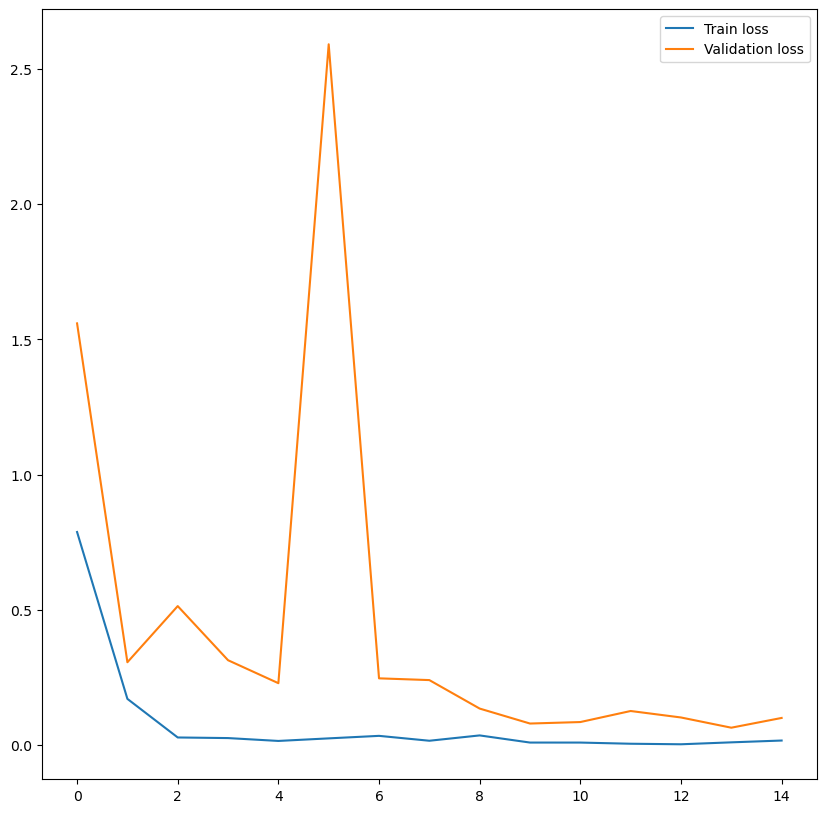

In [32]:
plt.figure(figsize=(10,10))
plt.plot(train_error, label="Train loss")
plt.plot(validation_error, label="Validation loss")
plt.legend()
plt.show()

#### Ratatuja